In [16]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('notebook')

The Murder Accountability Project's dataset in zipped csv format can be found here:

https://www.dropbox.com/s/ye37woe6et05qgs/SHR76_19.csv.zip?dl=1

Please note that the file size is 288MB when unzipped.

In [17]:
# Load raw dataset into dataframe, excluding unwanted columns
murders = pd.read_csv('C:\\Users\\Work_Remote\\Desktop\\Springboard\\Murder Project\\Data\\SHR76_19.csv').drop([
                'ID',
                'Source',
                'StateName',
                'Incident',
                'ActionType',
                'OffAge',
                'OffSex',
                'OffRace',
                'OffEthnic',
                'Relationship',
                'OffCount',
                'FileDate',
                'Circumstance',
                'Subcircum',
                'MSA',
                'Agency',
                'State',
                'CNTYFIPS'],
                axis=1)
    
murders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804751 entries, 0 to 804750
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Ori        804751 non-null  object
 1   Agentype   804751 non-null  object
 2   Solved     804751 non-null  object
 3   Year       804751 non-null  int64 
 4   Month      804751 non-null  object
 5   Homicide   804751 non-null  object
 6   Situation  804751 non-null  object
 7   VicAge     804751 non-null  int64 
 8   VicSex     804751 non-null  object
 9   VicRace    804751 non-null  object
 10  VicEthnic  804751 non-null  object
 11  Weapon     804751 non-null  object
 12  VicCount   804751 non-null  int64 
dtypes: int64(3), object(10)
memory usage: 79.8+ MB


In [18]:
# Create 'total agency cases' feature
cases_handled = murders.groupby('Ori')['Solved'].count()
cases_dict = dict(zip(cases_handled.index, cases_handled))

murders['AgencyCases'] = murders.Ori.apply(lambda x: cases_dict.get(x))

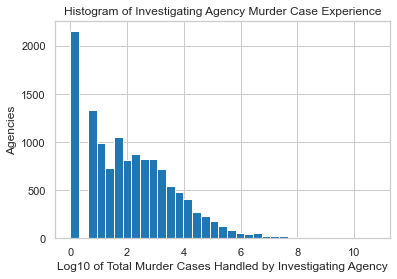

In [19]:
plt.hist(np.log(cases_handled), bins = 35)
plt.xlabel('Log10 of Total Murder Cases Handled by Investigating Agency')
plt.ylabel('Agencies')
plt.title('Histogram of Investigating Agency Murder Case Experience')
plt.show()

In [20]:
#Create 'agency white victim percent' column

#Group agencies by victim race counts, excluding victims of unknown race
murders_by_race = murders[murders.VicRace != 'Unknown'].groupby(['Ori', 'VicRace'])['Solved'].count()

murders_by_race = murders_by_race.unstack()
murders_by_race.fillna(0, inplace = True)
murders_by_race['WhitePercent'] = murders_by_race['White']/murders_by_race.sum(axis = 1)
race_dict = dict(zip(murders_by_race.index, murders_by_race['WhitePercent']))

murders['WhiteVictimPercent'] = murders.Ori.apply(lambda x: race_dict.get(x))
murders.WhiteVictimPercent[murders.WhiteVictimPercent.isnull()] = 0

<ipython-input-20-b585706f8d82>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  murders.WhiteVictimPercent[murders.WhiteVictimPercent.isnull()] = 0


Text(0, 0.5, 'Agencies')

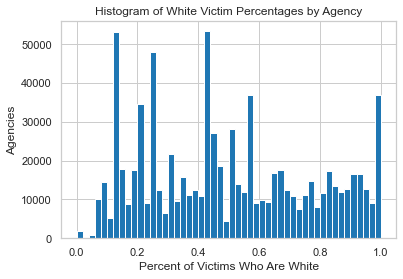

In [21]:
plt.hist(murders.WhiteVictimPercent, bins = 50)
plt.title('Histogram of White Victim Percentages by Agency')
plt.xlabel('Percent of Victims Who Are White')
plt.ylabel('Agencies')

In [23]:
#Adjusting 'Situation' to remove dependent variable leakage (but maybe capture a still meaningful feature):
murders['Situation'].replace(to_replace = ['Single victim/single offender',
                                           'Single victim/unknown offender(s)',
                                           'Single victim/multiple offenders'],
                             value = 'Single Victim',
                             inplace = True)

murders['Situation'].replace(to_replace = ['Multiple victims/single offender',
                                           'Multiple victims/unknown offender(s)',
                                           'Multiple victims/multiple offenders'],
                             value = 'Multiple Victims',
                             inplace = True)

In [24]:
murders.Situation.value_counts()

Single Victim       737523
Multiple Victims     67228
Name: Situation, dtype: int64

In [25]:
#Merge firearm categories in 'Weapon' to condense features
murders.Weapon.value_counts()

Handgun - pistol, revolver, etc         394363
Knife or cutting instrument             117868
Firearm, type not stated                 68428
Personal weapons, includes beating       46269
Other or type unknown                    41648
Shotgun                                  39071
Blunt object - hammer, club, etc         35638
Rifle                                    30109
Strangulation - hanging                  10038
Fire                                      7769
Asphyxiation - includes death by gas      4954
Other gun                                 3102
Narcotics or drugs, sleeping pills        2538
Drowning                                  1503
Explosives                                 625
Poison - does not include gas              569
Pushed or thrown out window                259
Name: Weapon, dtype: int64

In [26]:
murders.Weapon.replace(to_replace = ['Handgun - pistol, revolver, etc',
                                           'Firearm, type not stated',
                                           'Shotgun',
                                           'Rifle',
                                           'Other gun'],
                             value = 'Gun',
                             inplace = True)
murders.Weapon.value_counts()

Gun                                     535073
Knife or cutting instrument             117868
Personal weapons, includes beating       46269
Other or type unknown                    41648
Blunt object - hammer, club, etc         35638
Strangulation - hanging                  10038
Fire                                      7769
Asphyxiation - includes death by gas      4954
Narcotics or drugs, sleeping pills        2538
Drowning                                  1503
Explosives                                 625
Poison - does not include gas              569
Pushed or thrown out window                259
Name: Weapon, dtype: int64

In [27]:
# Drop weird Victim Counts - documentation states maximum value in 'VicCount' should be 10
murders = murders[murders.VicCount != 11]
murders = murders[murders.VicCount != 21]
murders.VicCount.value_counts().sort_index()

0     737789
1      49032
2      10587
3       3772
4       1431
5        620
6        379
7        224
8        200
9        420
10       264
Name: VicCount, dtype: int64

In [28]:
# Create age known/unknown column
murders['AgeKnown'] = murders.VicAge.apply(lambda x: 0 if x == 999 else 1)

In [29]:
# Change unknown ages to mean
average_age = np.mean(murders.VicAge)
print(average_age)
murders.VicAge[murders.VicAge == 999] = average_age

47.725711367211865


In [30]:
#Export cleaned dataset ready for pre-processing
murders.drop('Ori', axis = 1).to_csv(
    'C:\\Users\\Work_Remote\\Desktop\\murders_cleaned.csv', index = False)